In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


In [16]:
data_dir = "/media/abdul/8266fdc5-61f6-47d6-9e82-aa0e56f4b319/Ilyas/classification/cifar100/CIFAR100"

num_classes = 100
batch_size = 32
num_epochs = 10

model = models.mobilenet_v2(pretrained=True)
# Update model output size to 2.
model.classifier = nn.Linear(1280, num_classes)
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
       # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((32,32)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [7]:
train_dataset_size = len(image_datasets['train'])
val_dataset_size = len(image_datasets['val'])

print("Number of training samples: ", train_dataset_size)
print("Number of validation samples: ", val_dataset_size)

Number of training samples:  40000
Number of validation samples:  10000


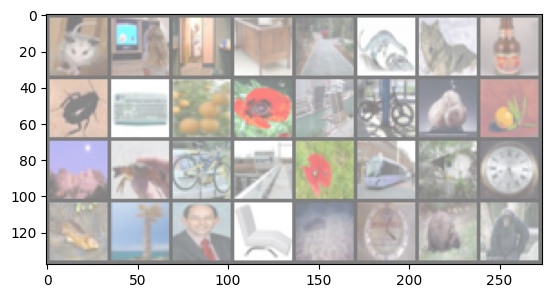

NameError: name 'classes' is not defined

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders_dict['train'])
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(2)))

In [9]:
model_ft = model.to(device)

params_to_update = []

for name, param in model_ft.named_parameters():
    param.requires_grad == False
    

for name,param in model_ft.named_parameters():

    if 'features.17' in name:
        param.requires_grad == True
        params_to_update.append(param)        

    if 'features.18' in name:
        param.requires_grad == True
        params_to_update.append(param)
        
    if 'classifier' in name:
        param.requires_grad == True
        params_to_update.append(param)

In [10]:
optimizer_ft = optim.SGD(params_to_update, lr=0.0005, momentum=0.9)

criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, 
                             dataloaders_dict, 
                             criterion, 
                             optimizer_ft, 
                             num_epochs=25)

----------
train Loss: 3.7557 Acc: 0.1421
val Loss: 3.2640 Acc: 0.2213

----------
train Loss: 3.2177 Acc: 0.2234
val Loss: 3.0404 Acc: 0.2548

----------
train Loss: 3.0618 Acc: 0.2489
val Loss: 2.9628 Acc: 0.2687

----------
train Loss: 2.9699 Acc: 0.2658
val Loss: 2.8931 Acc: 0.2814

----------
train Loss: 2.9114 Acc: 0.2766
val Loss: 2.8658 Acc: 0.2877

----------
train Loss: 2.8692 Acc: 0.2848
val Loss: 2.8709 Acc: 0.2918

----------
train Loss: 2.8291 Acc: 0.2922
val Loss: 2.7885 Acc: 0.2994

----------
train Loss: 2.7874 Acc: 0.2980
val Loss: 2.7988 Acc: 0.3003

----------
train Loss: 2.7613 Acc: 0.3054
val Loss: 2.8374 Acc: 0.3034

----------
train Loss: 2.7278 Acc: 0.3135
val Loss: 2.7488 Acc: 0.3112

----------
train Loss: 2.7025 Acc: 0.3162
val Loss: 2.7670 Acc: 0.3098

----------
train Loss: 2.6779 Acc: 0.3240
val Loss: 2.7690 Acc: 0.3060

----------
train Loss: 2.6610 Acc: 0.3265
val Loss: 2.7477 Acc: 0.3147

----------
train Loss: 2.6595 Acc: 0.3240
val Loss: 2.7160 Acc: 

In [11]:
class_names = image_datasets['train'].classes
print(class_names)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [20]:
img_test_transforms = transforms.Compose([
    transforms.Resize((32,32)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_data = torchvision.datasets.ImageFolder('/media/abdul/8266fdc5-61f6-47d6-9e82-aa0e56f4b319/Ilyas/classification/cifar100/CIFAR100/test',transform=img_test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          shuffle=False, num_workers=4)

In [21]:
# test-the-model
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 
           'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 
           'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab',
           'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
           'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 
           'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 
           'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
           'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

model_ft.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
       
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        i=0
        for label in labels:
            print("input",classes[label],"output",classes[predicted[i]])
           
            i=i+1

        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
    print('correct: {:d}  total: {:d}'.format(correct, total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')

input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output sweet_pepper
input apple output apple
input apple output apple
input apple output apple
input apple output sweet_pepper
input apple output tulip
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output pear
input apple output sweet_pepper
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output rose
input apple output apple
input apple output apple
input apple output apple
input apple output apple
input apple output mushroom
input apple output apple
input apple output apple
inp

input bottle output spider
input bottle output spider
input bottle output lamp
input bottle output castle
input bottle output cockroach
input bottle output chair
input bottle output whale
input bottle output streetcar
input bottle output woman
input bottle output girl
input bottle output pine_tree
input bottle output cup
input bottle output crab
input bottle output bottle
input bottle output bottle
input bottle output can
input bottle output girl
input bottle output can
input bottle output man
input bowl output orange
input bowl output sweet_pepper
input bowl output wolf
input bowl output bowl
input bowl output snake
input bowl output boy
input bowl output hamster
input bowl output bowl
input bowl output bowl
input bowl output bowl
input bowl output plate
input bowl output pear
input bowl output sweet_pepper
input bowl output cup
input bowl output plate
input bowl output plate
input bowl output plate
input bowl output plate
input bowl output girl
input bowl output bowl
input bowl outpu

input cattle output television
input cattle output pickup_truck
input cattle output elephant
input cattle output dinosaur
input cattle output crocodile
input cattle output castle
input cattle output raccoon
input cattle output cattle
input cattle output hamster
input cattle output shrew
input cattle output dinosaur
input cattle output cattle
input cattle output elephant
input cattle output cattle
input cattle output skunk
input cattle output chimpanzee
input cattle output bus
input cattle output lion
input cattle output cattle
input cattle output cattle
input cattle output cattle
input cattle output leopard
input cattle output elephant
input cattle output woman
input cattle output cattle
input cattle output bridge
input cattle output house
input cattle output rabbit
input cattle output cattle
input cattle output possum
input cattle output camel
input cattle output flatfish
input cattle output cattle
input cattle output fox
input cattle output can
input cattle output camel
input cattle 

input cup output lamp
input cup output lion
input cup output cup
input cup output lamp
input cup output chair
input cup output cup
input cup output butterfly
input cup output plain
input cup output whale
input cup output lawn_mower
input cup output bowl
input cup output cup
input cup output cup
input cup output wolf
input cup output cup
input cup output palm_tree
input cup output cup
input cup output cloud
input cup output cup
input cup output rabbit
input cup output orchid
input cup output cup
input cup output cup
input cup output cup
input cup output cup
input cup output cup
input cup output cup
input cup output cup
input cup output television
input cup output otter
input cup output dolphin
input cup output spider
input cup output chimpanzee
input cup output cup
input cup output road
input cup output lawn_mower
input cup output apple
input cup output rocket
input cup output flatfish
input cup output rocket
input cup output whale
input cup output cup
input cup output cup
input cup out

input kangaroo output lizard
input kangaroo output elephant
input kangaroo output road
input kangaroo output crocodile
input kangaroo output kangaroo
input kangaroo output shrew
input kangaroo output crocodile
input kangaroo output wolf
input kangaroo output kangaroo
input kangaroo output chair
input kangaroo output crocodile
input kangaroo output mushroom
input kangaroo output castle
input kangaroo output snail
input kangaroo output kangaroo
input kangaroo output lion
input kangaroo output kangaroo
input kangaroo output lamp
input kangaroo output fox
input kangaroo output snake
input kangaroo output lion
input kangaroo output lawn_mower
input kangaroo output crab
input kangaroo output train
input kangaroo output lion
input kangaroo output lion
input kangaroo output fox
input kangaroo output bicycle
input kangaroo output tractor
input kangaroo output chimpanzee
input kangaroo output palm_tree
input kangaroo output road
input kangaroo output kangaroo
input kangaroo output tractor
input 

input man output pine_tree
input man output man
input man output man
input man output beetle
input man output man
input man output flatfish
input man output chimpanzee
input man output television
input man output palm_tree
input man output bus
input man output tiger
input man output man
input man output bottle
input man output castle
input man output girl
input man output man
input man output aquarium_fish
input man output orchid
input man output dinosaur
input man output boy
input man output hamster
input man output table
input man output orchid
input man output chimpanzee
input man output apple
input man output flatfish
input man output bottle
input man output elephant
input maple_tree output maple_tree
input maple_tree output oak_tree
input maple_tree output willow_tree
input maple_tree output oak_tree
input maple_tree output willow_tree
input maple_tree output maple_tree
input maple_tree output crocodile
input maple_tree output pine_tree
input maple_tree output willow_tree
input ma

input otter output elephant
input otter output turtle
input otter output dinosaur
input otter output television
input otter output fox
input otter output seal
input otter output chimpanzee
input otter output otter
input otter output spider
input otter output otter
input otter output elephant
input otter output crocodile
input otter output cattle
input otter output road
input otter output porcupine
input otter output otter
input otter output shrew
input otter output otter
input otter output wolf
input otter output crab
input otter output train
input otter output cup
input otter output rocket
input otter output beaver
input otter output lion
input otter output dolphin
input otter output porcupine
input otter output otter
input otter output otter
input otter output chair
input otter output crocodile
input otter output chair
input otter output skunk
input otter output elephant
input otter output otter
input otter output bear
input otter output snail
input otter output lion
input otter outp

input possum output fox
input possum output bear
input possum output bicycle
input possum output leopard
input possum output elephant
input possum output rabbit
input possum output wolf
input possum output otter
input possum output bear
input possum output snake
input possum output crocodile
input possum output elephant
input possum output wolf
input possum output baby
input possum output snail
input possum output man
input possum output television
input possum output boy
input possum output lizard
input possum output road
input possum output lizard
input possum output possum
input possum output baby
input possum output camel
input possum output mouse
input possum output shrew
input possum output bicycle
input possum output seal
input possum output lizard
input possum output porcupine
input possum output baby
input possum output turtle
input possum output raccoon
input possum output wolf
input possum output bus
input possum output keyboard
input possum output lion
input possum output o

input shark output shark
input shark output dolphin
input shark output skunk
input shark output dolphin
input shark output ray
input shark output cup
input shark output seal
input shark output shark
input shark output ray
input shark output whale
input shark output shark
input shark output crab
input shark output cockroach
input shark output shark
input shark output whale
input shark output trout
input shark output seal
input shark output road
input shark output baby
input shark output shark
input shark output shark
input shark output whale
input shark output shark
input shark output ray
input shark output bear
input shark output dolphin
input shark output whale
input shark output shark
input shark output ray
input shark output shark
input shark output dolphin
input shark output dolphin
input shark output shark
input shark output television
input shark output shark
input shark output cloud
input shark output dolphin
input shark output shark
input shark output rocket
input shark output 

input sunflower output sunflower
input sunflower output sunflower
input sunflower output sunflower
input sunflower output sunflower
input sunflower output sunflower
input sunflower output sunflower
input sunflower output sunflower
input sunflower output sweet_pepper
input sunflower output sunflower
input sunflower output sunflower
input sunflower output poppy
input sunflower output sunflower
input sunflower output sunflower
input sunflower output orange
input sunflower output sunflower
input sunflower output sunflower
input sunflower output sunflower
input sunflower output sunflower
input sunflower output sunflower
input sunflower output sunflower
input sunflower output lobster
input sunflower output chimpanzee
input sunflower output sunflower
input sunflower output sunflower
input sunflower output beetle
input sunflower output forest
input sunflower output bee
input sunflower output sunflower
input sunflower output sunflower
input sunflower output cockroach
input sunflower output sunf

input trout output lawn_mower
input trout output butterfly
input trout output mushroom
input trout output otter
input trout output trout
input trout output crocodile
input trout output sea
input trout output cup
input trout output crocodile
input trout output tractor
input trout output tank
input trout output caterpillar
input trout output trout
input trout output train
input trout output turtle
input trout output kangaroo
input tulip output aquarium_fish
input tulip output forest
input tulip output rose
input tulip output orchid
input tulip output tulip
input tulip output orchid
input tulip output snail
input tulip output poppy
input tulip output poppy
input tulip output cup
input tulip output poppy
input tulip output rose
input tulip output orchid
input tulip output poppy
input tulip output rose
input tulip output orchid
input tulip output tulip
input tulip output rose
input tulip output mushroom
input tulip output forest
input tulip output orchid
input tulip output forest
input tuli

Test Accuracy of the model: 34.06 %
correct: 3406  total: 10000
